# Analytically Approximating the PSD of the Asymptotic $\Phi_n$ Transform

### Imports

In [1]:
import matplotlib.pyplot as plt
from dptcomp.dpfunc import s_n, c_n
import numpy as np
from dpt.transform import DPT, STPT, VVT
from scipy.optimize import curve_fit

### Generating White Noise

In [2]:
tMin, tMax = -100, -96
D          = int(tMax - tMin)
fs         = 4096
N          = fs * D
numSignals = 10_000
whiteNoiseMatrix = np.zeros((numSignals, N))
for i in range(numSignals):
    whiteNoiseMatrix[i, :] = np.random.normal(loc=0.0, scale=1.0, size=N)


### Generating DPT 

In [3]:
n             = 5/8
times         = np.arange(tMin, tMax, 1 / fs)
n_frequencies = np.arange(2 ** 0, 2 ** 15, 2 ** 5)
dptTransform  = DPT(n, times, n_frequencies)

Constructing S Matrix (Chirp Order 0.6250): 100%|██████████| 1024/1024 [06:07<00:00,  2.79it/s]


In [4]:
whiteNoiseASD, _ = dptTransform.transform(whiteNoiseMatrix.T)

In [5]:
def fit(omega, A):
    """ Predictions made by yours truly <3 """
    return A * omega ** (- 3 / 8)

In [6]:
idxMin = 10
whiteNoisePSD = np.median(np.abs(whiteNoiseASD[idxMin:, :]) ** 2, axis=1)
popt, pcov = curve_fit(fit, n_frequencies[idxMin:], whiteNoisePSD)
whiteNoisePSD = whiteNoisePSD / n_frequencies[idxMin:] ** (- 3 / 8)  # Flatten
whiteNoisePSD /= popt[0]

Let's study the region between $\omega_{\min}$ and $\omega_{\max}$ and see if it follows a $\chi^2$ ish distribution.

In [7]:
omega_min = 20_000
omega_max = 32_000 


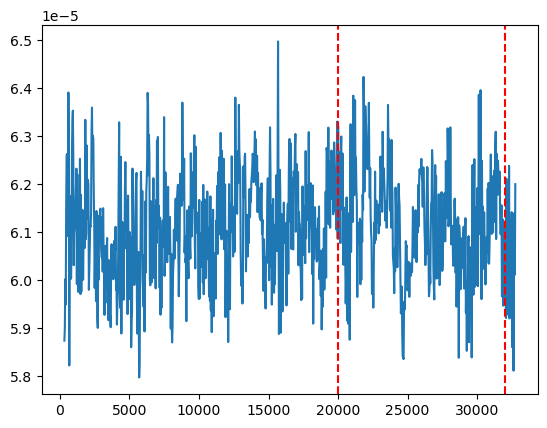

In [8]:
plt.plot(n_frequencies[idxMin:], whiteNoisePSD / (4 * fs))
plt.axvline(omega_min, color="red", linestyle="--")
plt.axvline(omega_max, color="red", linestyle="--")
plt.show()

In [9]:
chi2List = []
for col in range(np.shape(whiteNoiseASD)[1]):
    testSig          = whiteNoiseASD[:, col] / (popt[0] * n_frequencies ** (- 3 / 8) / D)
    testSigProjected = testSig[(n_frequencies >= omega_min) & (n_frequencies <= omega_max)]
    chi2List.append(sum(np.abs(testSigProjected) ** 2) * 1 / fs ** 2)
    
chi2Array = np.array(chi2List)

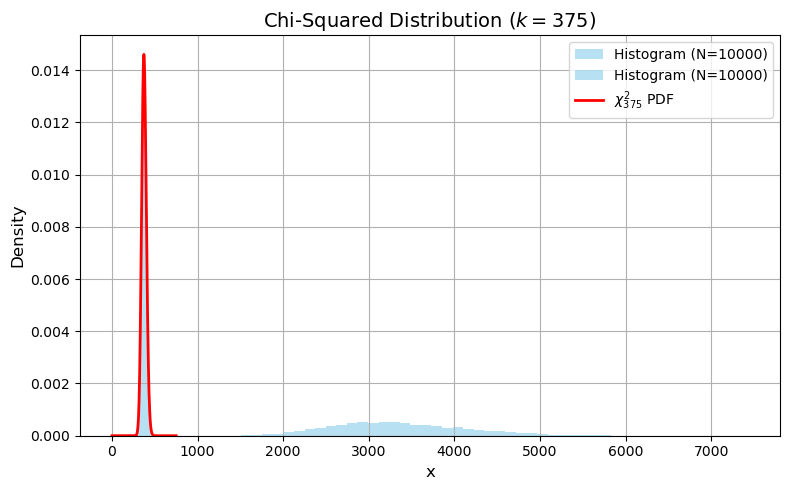

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2

# Parameters
df = len(n_frequencies[(n_frequencies >= omega_min) & (n_frequencies <= omega_max)]) # degrees of freedom
N_samples = 10000      # number of samples
x_range = np.linspace(0, df * 2, 500)  # x values for plotting PDF

# Generate chi-squared samples
samples = np.random.chisquare(df, N_samples)

# Compute theoretical PDF
pdf_vals = chi2.pdf(x_range, df)

# Plotting
fig, ax = plt.subplots(figsize=(8, 5))

# Histogram of samples
ax.hist(samples, bins=50, density=True, alpha=0.6, color='skyblue', label=f"Histogram (N={N_samples})")
ax.hist(chi2Array, bins=50, density=True, alpha=0.6, color='skyblue', label=f"Histogram (N={N_samples})")

# Plot chi-squared PDF
ax.plot(x_range, pdf_vals, 'r-', lw=2, label=rf"$\chi^2_{{{df}}}$ PDF")

# Decorations
ax.set_title(rf"Chi-Squared Distribution ($k={df}$)", fontsize=14)
ax.set_xlabel("x", fontsize=12)
ax.set_ylabel("Density", fontsize=12)
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()


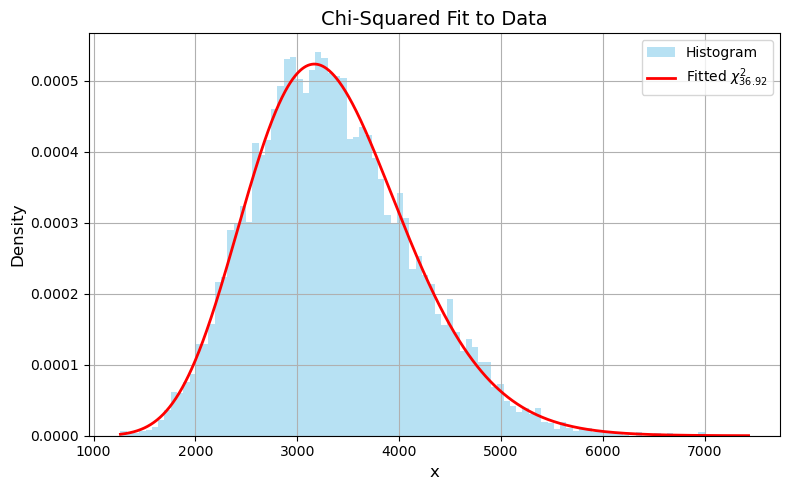

Fitted degrees of freedom: 36.9184
Fitted scale: 90.7229


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2

# Assume chi2Array exists
# Example for testing:
# chi2Array = np.random.chisquare(df=5, size=10000)

# Fit chi-squared distribution to the data
fitted_df, loc, scale = chi2.fit(chi2Array, floc=0)  # fix location to 0

# Histogram of the data
fig, ax = plt.subplots(figsize=(8, 5))
counts, bins, _ = ax.hist(chi2Array, bins=100, density=True, alpha=0.6, color="skyblue", label="Histogram")

# PDF of the fitted chi-squared
x = np.linspace(min(chi2Array), max(chi2Array), 1000)
pdf_fitted = chi2.pdf(x, df=fitted_df, loc=loc, scale=scale)
ax.plot(x, pdf_fitted, 'r-', lw=2, label=rf"Fitted $\chi^2_{{{fitted_df:.2f}}}$")

# Decorations
ax.set_title("Chi-Squared Fit to Data", fontsize=14)
ax.set_xlabel("x", fontsize=12)
ax.set_ylabel("Density", fontsize=12)
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()

# Optional: Print fit parameters
print(f"Fitted degrees of freedom: {fitted_df:.4f}")
print(f"Fitted scale: {scale:.4f}")


1000 1000


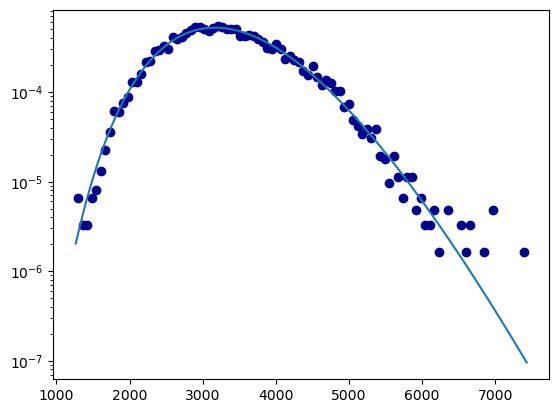

In [12]:
counts, bins, _ = ax.hist(chi2Array, bins=100, density=True, alpha=0.6, color="skyblue", label="Histogram")

bin_centers = 0.5 * (bins[:-1] + bins[1:])  # Compute centers of bins
print(len(x), len(pdf_fitted))
plt.scatter(bin_centers, counts, color="darkblue", label="Histogram points")
plt.plot(x, pdf_fitted)
plt.yscale('log')
plt.show()

In [15]:
pdf_fitted2 = chi2.pdf(bin_centers, df=fitted_df, loc=loc, scale=scale)
mask = pdf_fitted2 > 0
chi2Val = np.sum(((counts[mask] - pdf_fitted2[mask]) ** 2) / pdf_fitted2[mask])
print(chi2Val)

0.00022690576687456592
